In [1]:
import pandas as pd 
import numpy as np

# Processing
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso, ElasticNet, LogisticRegression

# Merics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import auc, roc_auc_score, precision_score, average_precision_score, \
    accuracy_score, balanced_accuracy_score, recall_score, confusion_matrix
from scipy.stats import pearsonr, spearmanr

# Viz
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kevinurban/miniconda3/lib/pytho

# Create the Data

In [2]:
target_cols = [
    'adscmat_labortype_spontaneousoraugmented_db', 
    'adsc_dlvry_dt', 
    'adsc_dlvrybefore28wks', 
    'adsc_dlvrybefore34wks', 
    'adsc_dlvryga_dys', 
    'adsc_dlvryga_dys_sbadj']

# Get Full Dataset
dff = pd.read_csv('../data/processed/full_set_v4_20200110_KU.csv')

# Set PatId Index
dff.set_index('patid', inplace=True)

# Remove Cesareans/Inductions
dff.query('adscmat_labortype_spontaneousoraugmented_db == 1', inplace=True)

# Remove records w/ GA@Birth < 25 wks (168 days is last day of week 24, so let's do 170 for clean cut off)
dff.query('adsc_dlvryga_dys >= 170', inplace=True)

# NEW: Remove records w/ GA@Recruitment > 25 weeks
dff.query('adelig_ccga <= 170', inplace=True)
dff.drop('adelig_ccga', axis=1, inplace=True)


# Feature Subsets
#  -- Sensor Cols:       Monica and Toitu Cols (usually; we dropped Monica above)
#  -- Toitu Cols:        Toitu Cols
#  -- Toitu F1 Cols:     Toitu F1 Cols
#  -- Toitu F1 Pwr Cols: Toitu F1 Power Cols (band21, band31, band41)
democlinical_cols = [col for col in dff.columns if 'sensor' not in col]
sensor_cols = [col for col in dff.columns if 'sensor' in col]
monica_cols = [col for col in sensor_cols if 'mon' in col]
toitu_cols = [col for col in sensor_cols if 'toi' in col]
toitu_f1_cols = [col for col in toitu_cols if 'f1' in col]
toitu_f1_pwr_cols = [col for col in toitu_f1_cols if 'pwr' in col]
toitu_f1_orthog_pwr_cols = [col for col in toitu_f1_pwr_cols if '41' not in col]
toitu_f3_cols = [col for col in toitu_cols if 'f3' in col]
toitu_f3_pwr_cols = [col for col in toitu_f3_cols if 'pwr' in col]


# NOTE: We are simply dropping all Monica Cols for this analysis
#rmssd_data_quality = [col for col in monica_cols 
#                     if 'rwaves' in col or 'perc' in col or 'epoch' in col]
#dff.drop(rmssd_data_quality, axis=1, inplace=True)
dff.drop(monica_cols, axis=1, inplace=True)


# Patient Subsets
#  -- Toitu F1 (906): patients with all 8 Toitu F1 vars
#  -- Toitu F1 Pwr (1853):  patients with all 3 Toitu F1 Power vars
#  -- Toitu F1 Orthog Power (1853):  patients with power bands 21 and 31
#  -- Toitu F1F3 (389): patients with all F1 and F3 vars
#  -- Toitu F1F3 Pwr (389):  patients with all F1 and F3 Power vars
toitu_f1_population = \
    dff[toitu_f1_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)
toitu_f1_pwr_population = \
    dff[toitu_f1_pwr_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)
toitu_f1_orthog_pwr_population = \
    dff[toitu_f1_orthog_pwr_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)
toitu_f1f3_population = \
    dff[toitu_f1_cols+toitu_f3_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)
toitu_f1f3_pwr_population = \
    dff[toitu_f1_cols+toitu_f3_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)


# Data Subsets (rows_cols_df)
##1
toif1_demo_df = dff.copy().loc[toitu_f1_pwr_population, democlinical_cols]
##2
toif1pwr_toif1pwr_df = dff.copy().loc[toitu_f1_pwr_population, target_cols + toitu_f1_pwr_cols]
##3
toif1pwr_demotoif1pwr_df = dff.copy().\
    loc[toitu_f1_pwr_population, democlinical_cols + toitu_f1_pwr_cols]


### EXTRAS: Only worth checking out if 3 pwr cols do well
toif1orthog_toif1orthog_df = dff.copy().\
    loc[toitu_f1_orthog_pwr_population, target_cols + toitu_f1_orthog_pwr_cols]
toif1orthog_demotoif1orthog_df = dff.copy().\
    loc[toitu_f1_orthog_pwr_population, democlinical_cols + toitu_f1_orthog_pwr_cols]

target_cols = [
    'adscmat_labortype_spontaneousoraugmented_db', 
    'adsc_dlvry_dt', 
    'adsc_dlvrybefore28wks', 
    'adsc_dlvrybefore34wks', 
    'adsc_dlvryga_dys', 
    'adsc_dlvryga_dys_sbadj'
]

# Experiments

Ok, make this all more deterministic...

* Add `random_state` to logistic regression and pass it the seed that everything
else gets passed
* Find a seed that produces AUC 0.99
* Find another seed that produces AUC 0.83

# Sanity Check:  Test Seed 83 (0.5 AUC?)
First thing I want to do is make sure I really have all the `random_state` instances
covered throughout the code.  If I do, then `seed=83` should result in `0.5 AUC`.

In [4]:
# INPUTS
target = 'adsc_dlvrybefore28wks'
data = toif1pwr_demotoif1pwr_df
seed=83
# AUC 50: 83
# AUC 66: 5, 17, 53, 61, 67, 73, 79, 89, 127
# AUC 83: 2, 11, 19, 31, 37, 41, 43, 71, 97, 101, 103, 107, 109
# AUC 99: 3, 7, 13, 23, 29, 47, 59, 113, 131
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(target_cols+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1).copy()
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]


# Employ Missing Indicator Method
missing_cols = [
    item for item in 
    x.replace(-999999,np.nan).isna().sum().to_frame('missing').query('missing > 0').index.tolist()
]
for col in missing_cols:
    x[col+'_missing'] = [1  if item==-999999 else 0 for item in x[col]]
    x[col] = x[col].replace(-999999, 0)

    
# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)

# SMOTE the training data
cats = [idx for idx,col in enumerate(x_trn.columns) if len(x[col].unique()) < 10]
sm = SMOTENC(cats, random_state=seed)
x_trn, y_trn = sm.fit_resample(x_trn.values, y_trn.values.ravel())

# Fit Model
model = LogisticRegression(penalty='l1', solver='liblinear', 
                          random_state=seed)
model.fit(x_trn, y_trn)

# Make Predictions
yp_trn = model.predict(x_trn)
yp_val = model.predict(x_val)


print('AUC:', roc_auc_score(y_val, yp_val))

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


AUC: 0.4972875226039783


# Classify Seed Behaviors
**2020-Jan-28**

One of the things I found after going through 30 or so (prime number) seeds is
that we do not only have the `AUC83` and `AUC99` classes:  there also exists
the `AUC50` and `AUC66` classes.  It seems that `AUC50` is pretty rare, having only
found one instance, but that `AUC66` is actually about as common as `AUC99`.  

What I want to do is find the class for all seed in the range \[0,250).

In [3]:
running_this_again_is_a_good_idea=False

if running_this_again_is_a_good_idea:
    import warnings
    warnings.filterwarnings(action='ignore') # so many annoying warnings for this cell

    target = 'adsc_dlvrybefore28wks'
    data = toif1pwr_demotoif1pwr_df

    #---------------
    # Define Scenario Data (only Demo/Clinical)
    x = data.drop(target_cols+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1).copy()
    y = data[[target]].copy()

    # Only keep records with non-missing target value
    valid_target_index = y[target].replace(-999999, np.nan).dropna().index
    x = x.loc[valid_target_index,:]
    y = y.loc[valid_target_index,:]


    # Employ Missing Indicator Method
    missing_cols = [
        item for item in 
        x.replace(-999999,np.nan).isna().sum().to_frame('missing').query('missing > 0').index.tolist()
    ]
    for col in missing_cols:
        x[col+'_missing'] = [1  if item==-999999 else 0 for item in x[col]]
        x[col] = x[col].replace(-999999, 0)
    #---------


    auc50 = list()
    auc66 = list()
    auc83 = list()
    auc99 = list()
    seed = 0
    for seed in range(250):
        # Split Data
        x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)

        # SMOTE the training data
        cats = [idx for idx,col in enumerate(x_trn.columns) if len(x[col].unique()) < 10]
        sm = SMOTENC(cats, random_state=seed)
        x_trn, y_trn = sm.fit_resample(x_trn.values, y_trn.values.ravel())

        # Fit Model
        model = LogisticRegression(penalty='l1', solver='liblinear', 
                          random_state=seed)
        model.fit(x_trn, y_trn)

        # Make Predictions
        yp_trn = model.predict(x_trn)
        yp_val = model.predict(x_val)

        auc = roc_auc_score(y_val, yp_val)
        if auc < 0.52:
            auc50.append(seed)
            #print('50:', auc50)
        elif 0.65 < auc and auc < 0.67:
            auc66.append(seed)
            #print('66:', auc66)
        elif 0.82 < auc and auc < 0.84:
            auc83.append(seed)
            #print('83:', auc83)
        elif 0.989 < auc: 
            auc99.append(seed)
            #print('99:', auc99)
else:
    # These are the lists I captured from running the loop the first time
    auc50 = [42, 83, 117, 161, 163, 213, 232, 235, 242, 244]
    auc66 = [0, 4, 5, 6, 17, 22, 26, 33, 38, 45, 49, 51, 52, 53, 
             54, 55, 61, 62, 67, 72, 73, 79, 84, 87, 89, 91, 95, 
             100, 120, 125, 127, 128, 129, 130, 133, 134, 138, 140, 
             141, 143, 144, 147, 148, 149, 153, 157, 165, 167, 170, 
             174, 178, 182, 186, 192, 197, 209, 210, 215, 218, 220, 
             222, 229, 230, 236, 243, 248]
    auc83 = [1, 2, 8, 11, 12, 15, 16, 18, 19, 20, 24, 25, 27, 28, 
             30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 43, 46, 48, 
             50, 56, 57, 58, 63, 64, 68, 69, 70, 71, 75, 78, 82, 
             86, 88, 90, 92, 93, 94, 96, 97, 98, 101, 102, 103, 
             104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 
             115, 116, 118, 119, 121, 126, 132, 135, 137, 142, 
             145, 150, 151, 152, 154, 155, 158, 159, 160, 162, 
             164, 168, 171, 173, 175, 176, 177, 179, 180, 183, 
             184, 187, 188, 189, 195, 196, 198, 199, 200, 205, 
             206, 207, 214, 217, 223, 227, 228, 231, 233, 234, 
             238, 240, 245, 246, 249]
    auc99 = [3, 7, 9, 10, 13, 14, 21, 23, 29, 44, 47, 59, 60, 65, 
             66, 74, 76, 77, 80, 81, 85, 99, 113, 122, 123, 124, 
             131, 136, 139, 146, 156, 166, 169, 172, 181, 185, 
             190, 191, 193, 194, 201, 202, 203, 204, 208, 211, 
             212, 216, 219, 221, 224, 225, 226, 237, 239, 241, 247]
    


### RESULTS
I record the results of the 250 random seeds here so that they persist after this
notebook is shutdown.  (Could also save them too, ya know.  "Shut up, brain!")


* **AUC 50**: \[42, 83, 117, 161, 163, 213, 232, 235, 242, 244\]
* **AUC 66**: \[0, 4, 5, 6, 17, 22, 26, 33, 38, 45, 49, 51, 52, 53, 54, 55, 61, 62, 67, 72, 73, 79, 84, 87, 89, 91, 95, 100, 120, 125, 127, 128, 129, 130, 133, 134, 138, 140, 141, 143, 144, 147, 148, 149, 153, 157, 165, 167, 170, 174, 178, 182, 186, 192, 197, 209, 210, 215, 218, 220, 222, 229, 230, 236, 243, 248\]
* **AUC 83**: \[1, 2, 8, 11, 12, 15, 16, 18, 19, 20, 24, 25, 27, 28, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 43, 46, 48, 50, 56, 57, 58, 63, 64, 68, 69, 70, 71, 75, 78, 82, 86, 88, 90, 92, 93, 94, 96, 97, 98, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 118, 119, 121, 126, 132, 135, 137, 142, 145, 150, 151, 152, 154, 155, 158, 159, 160, 162, 164, 168, 171, 173, 175, 176, 177, 179, 180, 183, 184, 187, 188, 189, 195, 196, 198, 199, 200, 205, 206, 207, 214, 217, 223, 227, 228, 231, 233, 234, 238, 240, 245, 246, 249\]
* **AUC 99**: \[3, 7, 9, 10, 13, 14, 21, 23, 29, 44, 47, 59, 60, 65, 66, 74, 76, 77, 80, 81, 85, 99, 113, 122, 123, 124, 131, 136, 139, 146, 156, 166, 169, 172, 181, 185, 190, 191, 193, 194, 201, 202, 203, 204, 208, 211, 212, 216, 219, 221, 224, 225, 226, 237, 239, 241, 247\]

### One last question on that:  Are the 4 classes exhaustive?  (i.e., did all seeds make it into a class?)
The answer is YES.  There is no number in `range(250)` that was not put into one of 
our classes.  Crazy.

In [7]:
[item for item in range(250) if item not in auc50+auc66+auc83+auc99]

[]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132593da0>]],
      dtype=object)

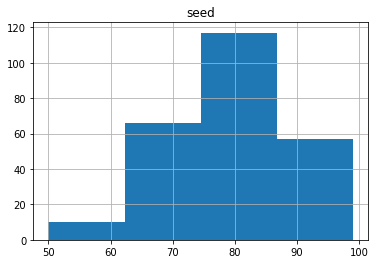

In [20]:
pd.DataFrame(np.concatenate([
    np.repeat(50,len(auc50)), 
    np.repeat(66,len(auc66)),
    np.repeat(83,len(auc83)),
    np.repeat(99,len(auc99))
]), columns=['seed']).hist(bins=4)

In [22]:
len(auc99)

57

# Patient Populations

In [27]:
auc50

[42, 83, 117, 161, 163, 213, 232, 235, 242, 244]

In [52]:
y.query('adsc_dlvrybefore28wks == 1').index

Index(['S002-BISH-01907', 'S002-BISH-02409', 'S002-BISH-03841',
       'S002-BISH-03857', 'S002-BISH-03957', 'S002-BISH-04628',
       'S002-BISH-04647', 'S002-BISH-04937', 'S002-BISH-05908',
       'S002-BISH-06497', 'S002-BISH-06632'],
      dtype='object', name='patid')

In [57]:
# INPUTS
target = 'adsc_dlvrybefore28wks'
data = toif1pwr_demotoif1pwr_df

# AUC 50: 83
# AUC 66: 5, 17, 53, 61, 67, 73, 79, 89, 127
# AUC 83: 2, 11, 19, 31, 37, 41, 43, 71, 97, 101, 103, 107, 109
# AUC 99: 3, 7, 13, 23, 29, 47, 59, 113, 131
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(target_cols+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1).copy()
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

pid = dict()
events_trn = dict()
events_val = dict()
common = None
events = y.query('adsc_dlvrybefore28wks == 1').index
for seed in auc50:
    # Split Data
    x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)
    pid[seed] = x_trn.index
    if common is None:
        common = set(pid[seed].tolist())
    else:
        common = common.intersection(pid[seed])
    events_trn[seed] = y_trn.query('adsc_dlvrybefore28wks == 1').index
    events_val[seed] = y_val.query('adsc_dlvrybefore28wks == 1').index


In [36]:
# Training (1297)
pid[42]

Index(['S002-BISH-01248', 'S002-BISH-05271', 'S002-BISH-00855',
       'S002-BISH-06276', 'S002-BISH-00929', 'S002-BISH-02405',
       'S002-BISH-00842', 'S002-BISH-04087', 'S002-BISH-00569',
       'S002-BISH-03274',
       ...
       'S002-BISH-00479', 'S002-BISH-04698', 'S002-BISH-01456',
       'S002-BISH-04333', 'S002-BISH-04379', 'S002-BISH-03593',
       'S002-BISH-03609', 'S002-BISH-00324', 'S002-BISH-00038',
       'S002-BISH-05725'],
      dtype='object', name='patid', length=1297)

In [37]:
set(pid[42].tolist()).intersection(pid[83]).__len__()

903

In [40]:
common.__len__()

54

In [48]:
y.loc[common].sum()

adsc_dlvrybefore28wks    4.0
dtype: float64

In [47]:
y.sum()

adsc_dlvrybefore28wks    11.0
dtype: float64

I'm wondering if AUC50 seeds correspond to times when patient X and patient Y
(i) are in opposite sets
(ii) same set

In [71]:
events = y.query('adsc_dlvrybefore28wks == 1').index

print('Opposites')
for patient in events:
    opposite = None
    for seed in auc50:
        if patient in events_trn[seed]:
            if opposite is None:
                opposite = set(events_val[seed].tolist())
            else:
                opposite = opposite.intersection(events_val[seed])
        else:
            if opposite is None:
                opposite = set(events_trn[seed].tolist())
            else:
                opposite = opposite.intersection(events_trn[seed])
        print(patient, opposite)

print('\nCommons')
for patient in events:
    common = None
    for seed in auc50:
        if patient in events_trn[seed]:
            if common is None:
                print('Training...')
                common = set(events_trn[seed].tolist())
            else:
                common = common.intersection(events_trn[seed])
        else:
            if common is None:
                print('Validation...')
                common = set(events_val[seed].tolist())
            else:
                common = common.intersection(events_val[seed])
    print(patient, common)

Opposites
S002-BISH-01907 {'S002-BISH-03841', 'S002-BISH-04647', 'S002-BISH-03957'}
S002-BISH-01907 {'S002-BISH-03841'}
S002-BISH-01907 {'S002-BISH-03841'}
S002-BISH-01907 set()
S002-BISH-01907 set()
S002-BISH-01907 set()
S002-BISH-01907 set()
S002-BISH-01907 set()
S002-BISH-01907 set()
S002-BISH-01907 set()
S002-BISH-02409 {'S002-BISH-03841', 'S002-BISH-04647', 'S002-BISH-03957'}
S002-BISH-02409 {'S002-BISH-03841'}
S002-BISH-02409 {'S002-BISH-03841'}
S002-BISH-02409 set()
S002-BISH-02409 set()
S002-BISH-02409 set()
S002-BISH-02409 set()
S002-BISH-02409 set()
S002-BISH-02409 set()
S002-BISH-02409 set()
S002-BISH-03841 {'S002-BISH-04628', 'S002-BISH-03857', 'S002-BISH-05908', 'S002-BISH-04937', 'S002-BISH-01907', 'S002-BISH-02409', 'S002-BISH-06632', 'S002-BISH-06497'}
S002-BISH-03841 {'S002-BISH-03857', 'S002-BISH-05908', 'S002-BISH-02409', 'S002-BISH-01907', 'S002-BISH-06497', 'S002-BISH-04937'}
S002-BISH-03841 {'S002-BISH-03857', 'S002-BISH-01907', 'S002-BISH-02409', 'S002-BISH-06497

In [144]:
the4pack = ['S002-BISH-06497', 'S002-BISH-04937', 'S002-BISH-02409', 'S002-BISH-03857']

In [66]:
events_val[42]

Index(['S002-BISH-03841', 'S002-BISH-03957', 'S002-BISH-04647'], dtype='object', name='patid')

In [67]:
common04937

set()

# The 4 Patients

For every AUC 0.5, these patients/events show up in the training set:
```
{'S002-BISH-06497', 'S002-BISH-04937', 'S002-BISH-02409', 'S002-BISH-03857'}
```

In almost all of AUC 0.5 seeds, these patients/events are in opposite set:
```
{S002-BISH-04628, 'S002-BISH-04647'}
```

Next experiment: 
* try swapping two of them with patients from validation set

### A. Improving Upon AUC 0.5

In [135]:
# INPUTS
target = 'adsc_dlvrybefore28wks'
data = toif1pwr_demotoif1pwr_df
seed=83
# AUC 50: 83
# AUC 66: 5, 17, 53, 61, 67, 73, 79, 89, 127
# AUC 83: 2, 11, 19, 31, 37, 41, 43, 71, 97, 101, 103, 107, 109
# AUC 99: 3, 7, 13, 23, 29, 47, 59, 113, 131
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(target_cols+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1).copy()
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]


# Employ Missing Indicator Method
missing_cols = [
    item for item in 
    x.replace(-999999,np.nan).isna().sum().to_frame('missing').query('missing > 0').index.tolist()
]
for col in missing_cols:
    x[col+'_missing'] = [1  if item==-999999 else 0 for item in x[col]]
    x[col] = x[col].replace(-999999, 0)

    
# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)


########################################################################
# Define Swap Sets
val2trn = y_val.query('adsc_dlvrybefore28wks == 1').index[:2]
trn2val = ['S002-BISH-06497', 'S002-BISH-04937']

# Swap Patients
y_trn = y_trn.append(y_val.loc[val2trn])
x_trn = x_trn.append(x_val.loc[val2trn])

y_val = y_val.append(y_trn.loc[trn2val]).drop(val2trn, axis=0)
x_val = x_val.append(x_trn.loc[trn2val]).drop(val2trn, axis=0)

y_trn.drop(trn2val, axis=0, inplace=True)
x_trn.drop(trn2val, axis=0, inplace=True)
########################################################################


# SMOTE the training data
cats = [idx for idx,col in enumerate(x_trn.columns) if len(x[col].unique()) < 10]
sm = SMOTENC(cats, random_state=seed)
x_trn, y_trn = sm.fit_resample(x_trn.values, y_trn.values.ravel())

# Fit Model
model = LogisticRegression(penalty='l1', solver='liblinear', 
                          random_state=seed)
model.fit(x_trn, y_trn)

# Make Predictions
yp_trn = model.predict(x_trn)
yp_val = model.predict(x_val)


print('AUC:', roc_auc_score(y_val, yp_val))

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


AUC: 0.8306208559373116


As suspected, ensure that there is representation from this special "4 pack" in both training and
validation, the AUC will increase.

But why?  Are they identical rows?

Not exactly:
* below we find that 54 of the 187 features are not identical
* however, many of them are "\_missing" features
    - 19 are non-missing features
    - 35 are missing features
* the non-missing, non-constant columns are:
    - 'adafppappa_afpmom', 'adedin_edinburgh_raw_all-10-15-20_db',
       'adelig_mat_age', 'adfetalgrowth_deviationindex', 'admh_hxab2',
       'admh_anemia3', 'adsc_gender2', 'adscmat_educ_combohs4', 'adscmat_empl',
       'adscmat_empl_comb4', 'adscmat_grossincome7', 'adsmk_avgnumcighome',
       'adstai_s_anxiety', 'adstai_t_anxiety', 'advs_height',
       'advs_prepregweight', 'advs_prepregbmi', 'sensor_toi_f1_mvt_pwr_mvt21',
       'sensor_toi_f1_mvt_pwr_mvt31'
* but, wait!  It's the constant cols that are actually important here since these
  patients are "predictive of each other"
  - that is, at least one of these patients needs to be in training to predict the
    remainders in val
  - if all 4 patients are training, they provide no predictive power to validation
  - however, we do find there is at least one other pair (outside the 4pack) that 
    contributes to predictive power (see next section below)

Next, I'll look in diminshing the AUC of a AUC99 seed.

Then, in next section, I'll look at the top features for all the AUC 0.99 models.

In [137]:
df = x.loc[['S002-BISH-06497', 'S002-BISH-04937', 'S002-BISH-02409', 'S002-BISH-03857']]
df.loc[:, (df != df.iloc[0]).any()].shape

(4, 54)

In [141]:
df.loc[:, (df != df.iloc[0]).any()].filter(regex='^(?!.*missing)').shape

(4, 19)

In [142]:
df.loc[:, (df != df.iloc[0]).any()].filter(regex='^(?!.*missing)').columns

Index(['adafppappa_afpmom', 'adedin_edinburgh_raw_all-10-15-20_db',
       'adelig_mat_age', 'adfetalgrowth_deviationindex', 'admh_hxab2',
       'admh_anemia3', 'adsc_gender2', 'adscmat_educ_combohs4', 'adscmat_empl',
       'adscmat_empl_comb4', 'adscmat_grossincome7', 'adsmk_avgnumcighome',
       'adstai_s_anxiety', 'adstai_t_anxiety', 'advs_height',
       'advs_prepregweight', 'advs_prepregbmi', 'sensor_toi_f1_mvt_pwr_mvt21',
       'sensor_toi_f1_mvt_pwr_mvt31'],
      dtype='object')

### B. Ruining a AUC 0.99 Seed

In [145]:
the4pack = ['S002-BISH-06497', 'S002-BISH-04937', 'S002-BISH-02409', 'S002-BISH-03857']

In [198]:
# INPUTS
target = 'adsc_dlvrybefore28wks'
data = toif1pwr_demotoif1pwr_df
seed=3
# AUC 50: 83
# AUC 66: 5, 17, 53, 61, 67, 73, 79, 89, 127
# AUC 83: 2, 11, 19, 31, 37, 41, 43, 71, 97, 101, 103, 107, 109
# AUC 99: 3, 7, 13, 23, 29, 47, 59, 113, 131
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(target_cols+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1).copy()
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]


# Employ Missing Indicator Method
missing_cols = [
    item for item in 
    x.replace(-999999,np.nan).isna().sum().to_frame('missing').query('missing > 0').index.tolist()
]
for col in missing_cols:
    x[col+'_missing'] = [1  if item==-999999 else 0 for item in x[col]]
    x[col] = x[col].replace(-999999, 0)

    
# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)


########################################################################

# Define Swap Sets
val2trn = [patient for patient in the4pack if patient in y_val.index]
#trn2val = [patient for patient in y_trn.query('adsc_dlvrybefore28wks == 1').index 
#           if patient not in the4pack][4:4+len(val2trn)]
trn2val = ['S002-BISH-04647', 'S002-BISH-05908']

# Swap Patients
y_trn = y_trn.append(y_val.loc[val2trn])
x_trn = x_trn.append(x_val.loc[val2trn])

y_val = y_val.append(y_trn.loc[trn2val]).drop(val2trn, axis=0)
x_val = x_val.append(x_trn.loc[trn2val]).drop(val2trn, axis=0)

y_trn.drop(trn2val, axis=0, inplace=True)
x_trn.drop(trn2val, axis=0, inplace=True)

########################################################################


# SMOTE the training data
cats = [idx for idx,col in enumerate(x_trn.columns) if len(x[col].unique()) < 10]
sm = SMOTENC(cats, random_state=seed)
x_trn, y_trn = sm.fit_resample(x_trn.values, y_trn.values.ravel())

# Fit Model
model = LogisticRegression(penalty='l1', solver='liblinear', 
                          random_state=seed)
model.fit(x_trn, y_trn)

# Make Predictions
yp_trn = model.predict(x_trn)
yp_val = model.predict(x_val)


print('AUC:', roc_auc_score(y_val, yp_val))

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


AUC: 0.832429174201326


In [199]:
trn2val

['S002-BISH-04647', 'S002-BISH-05908']

SUCCESS!

We've ruined the 0.99 AUC and made it 0.66.  Since the entire 4pack is in training this
time, we know there is a little signal left.

But if you change which patients you swap from training event to validation, you can toggle this AUC:

| AUC | trn2val |
|----|----------|
| 0.66 | <font color='green'>'S002-BISH-06632'</font>, <font color='red'>'S002-BISH-03841'</font> |
| 0.83 | 'S002-BISH-03841', 'S002-BISH-03957' |
| 0.83 | 'S002-BISH-03957', 'S002-BISH-04647' |
| 0.66 | 'S002-BISH-04647', 'S002-BISH-01907' |
| 0.83 | 'S002-BISH-01907', 'S002-BISH-05908' |


`S002-BISH-06632`

| AUC | trn2val |
|----|----------|
| 0.66 | <font color='green'>'S002-BISH-06632'</font>, <font color='red'>'S002-BISH-03841'</font> |
| 0.83 | <font color='green'>'S002-BISH-06632'</font>, <font color='green'>'S002-BISH-03957'</font> |
| 0.66 | <font color='green'>'S002-BISH-06632'</font>, <font color='red'>'S002-BISH-04647'</font> |
| 0.66 | <font color='green'>'S002-BISH-06632'</font>, <font color='red'>'S002-BISH-01907'</font> |
| 0.83 | <font color='green'>'S002-BISH-06632'</font>, <font color='green'>'S002-BISH-05908'</font> |

`S002-BISH-04647`

| AUC | trn2val |
|----|----------|
| 0.66 | <font color='green'>'S002-BISH-04647'</font>, <font color='red'>'S002-BISH-03841'</font> | 
| 0.66 | <font color='green'>'S002-BISH-04647'</font>, <font color='red'>'S002-BISH-06632'</font> |
| 0.83 | <font color='green'>'S002-BISH-04647'</font>, <font color='green'>'S002-BISH-05908'</font>|
| 0.83 | <font color='green'>'S002-BISH-04647'</font>, <font color='green'>'S002-BISH-03957'</font> |
| 0.66 | <font color='green'>'S002-BISH-04647'</font>, <font color='red'>'S002-BISH-01907'</font> |



# AUC 0.99:  Top of the Top Features

In [208]:
import warnings
warnings.filterwarnings(action='ignore') # so many annoying warnings for this cell

# INPUTS
target = 'adsc_dlvrybefore28wks'
data = toif1pwr_demotoif1pwr_df
seed=83
# AUC 50: 83
# AUC 66: 5, 17, 53, 61, 67, 73, 79, 89, 127
# AUC 83: 2, 11, 19, 31, 37, 41, 43, 71, 97, 101, 103, 107, 109
# AUC 99: 3, 7, 13, 23, 29, 47, 59, 113, 131
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(target_cols+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1).copy()
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]


# Employ Missing Indicator Method
missing_cols = [
    item for item in 
    x.replace(-999999,np.nan).isna().sum().to_frame('missing').query('missing > 0').index.tolist()
]
for col in missing_cols:
    x[col+'_missing'] = [1  if item==-999999 else 0 for item in x[col]]
    x[col] = x[col].replace(-999999, 0)


imps = pd.DataFrame(columns = ['ftr','imp','sign'])
for seed in auc99:
    # Split Data
    x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)

    # SMOTE the training data
    cats = [idx for idx,col in enumerate(x_trn.columns) if len(x[col].unique()) < 10]
    sm = SMOTENC(cats, random_state=seed)
    x_trn, y_trn = sm.fit_resample(x_trn.values, y_trn.values.ravel())

    # Fit Model
    model = LogisticRegression(penalty='l1', solver='liblinear', 
                          random_state=seed)
    model.fit(x_trn, y_trn)

    # Make Predictions
    yp_trn = model.predict(x_trn)
    yp_val = model.predict(x_val)


    #print('AUC:', roc_auc_score(y_val, yp_val))
    
    feature_importance = abs(model.coef_[0])
    rank = np.flip(np.argsort(feature_importance))
    imps = pd.concat([
        imps,
        pd.DataFrame({
            'ftr': x.columns[rank], 
            'imp': feature_importance[rank], 
            'sign': np.sign(model.coef_[0][rank])
        })])
    

AUC: 0.9981916817359856
AUC: 0.9981916817359856
AUC: 0.9972875226039782
AUC: 0.9972875226039782
AUC: 0.9981916817359856
AUC: 0.9990958408679927
AUC: 0.9972875226039782
AUC: 0.9972875226039782
AUC: 0.9927667269439422
AUC: 0.9972875226039782
AUC: 0.9954792043399638
AUC: 0.9936708860759494
AUC: 0.9990958408679927
AUC: 0.9972875226039782
AUC: 0.9954792043399638
AUC: 0.9981916817359856
AUC: 0.9981916817359856
AUC: 0.996383363471971
AUC: 0.9981916817359856
AUC: 0.9945750452079566
AUC: 0.9972875226039782
AUC: 0.9990958408679927
AUC: 0.9972875226039782
AUC: 0.996383363471971
AUC: 0.9981916817359856
AUC: 0.996383363471971
AUC: 0.9981916817359856
AUC: 0.9981916817359856
AUC: 0.9990958408679927
AUC: 0.996383363471971
AUC: 0.996383363471971
AUC: 0.9990958408679927
AUC: 0.996383363471971
AUC: 0.996383363471971
AUC: 0.996383363471971
AUC: 0.9981916817359856
AUC: 0.9981916817359856
AUC: 0.996383363471971
AUC: 0.9954792043399638
AUC: 0.9990958408679927
AUC: 0.9972875226039782
AUC: 0.9972875226039782
A

In [231]:
imps.shape

(10659, 3)

In [237]:
imps.groupby('ftr').mean().sort_values(by='imp',ascending=False).reset_index()

,ftr,imp,sign
0,alcsmk_t2_avecigs.wk_missing,4.817564,1.000000
1,alcsmk_t1_avecigs.wk_missing,4.664752,1.000000
2,alcsmk_t1_alc_missing,1.971824,-1.000000
3,alcsmk_bt2_missing,1.755560,-1.000000
4,alcsmk_t2_alc_missing,1.668113,-1.000000
5,alcsmk_bt1_missing,1.600763,-1.000000
6,adscmat_grossincome7_missing,1.354289,-0.842105
7,adscmat_educ_combohs4,1.211004,-1.000000
8,adscmat_empl_comb4_missing,0.991879,-0.789474
9,admh_anemia3,0.975911,-0.964912


One thing is clear:  missingness in the alcsmk table is the dead give away.  

In [244]:
top6alcsmk = imps.groupby('ftr').mean().sort_values(by='imp',ascending=False).reset_index().imp[:6].sum()
total = imps.groupby('ftr').mean().sort_values(by='imp',ascending=False).reset_index().imp.sum()
print(round(100 * top6alcsmk / total, 1))

65.3


In [275]:
top6 = imps.groupby('ftr').mean().sort_values(by='imp',ascending=False).reset_index()[:6].ftr.tolist()
top6

['alcsmk_t2_avecigs.wk_missing',
 'alcsmk_t1_avecigs.wk_missing',
 'alcsmk_t1_alc_missing',
 'alcsmk_bt2_missing',
 'alcsmk_t2_alc_missing',
 'alcsmk_bt1_missing']

It accounts for 65% of all averaged importances.



In [312]:
import missingno
import seaborn as sns
top6y = pd.concat([x.loc[:,top6],y], axis=1)

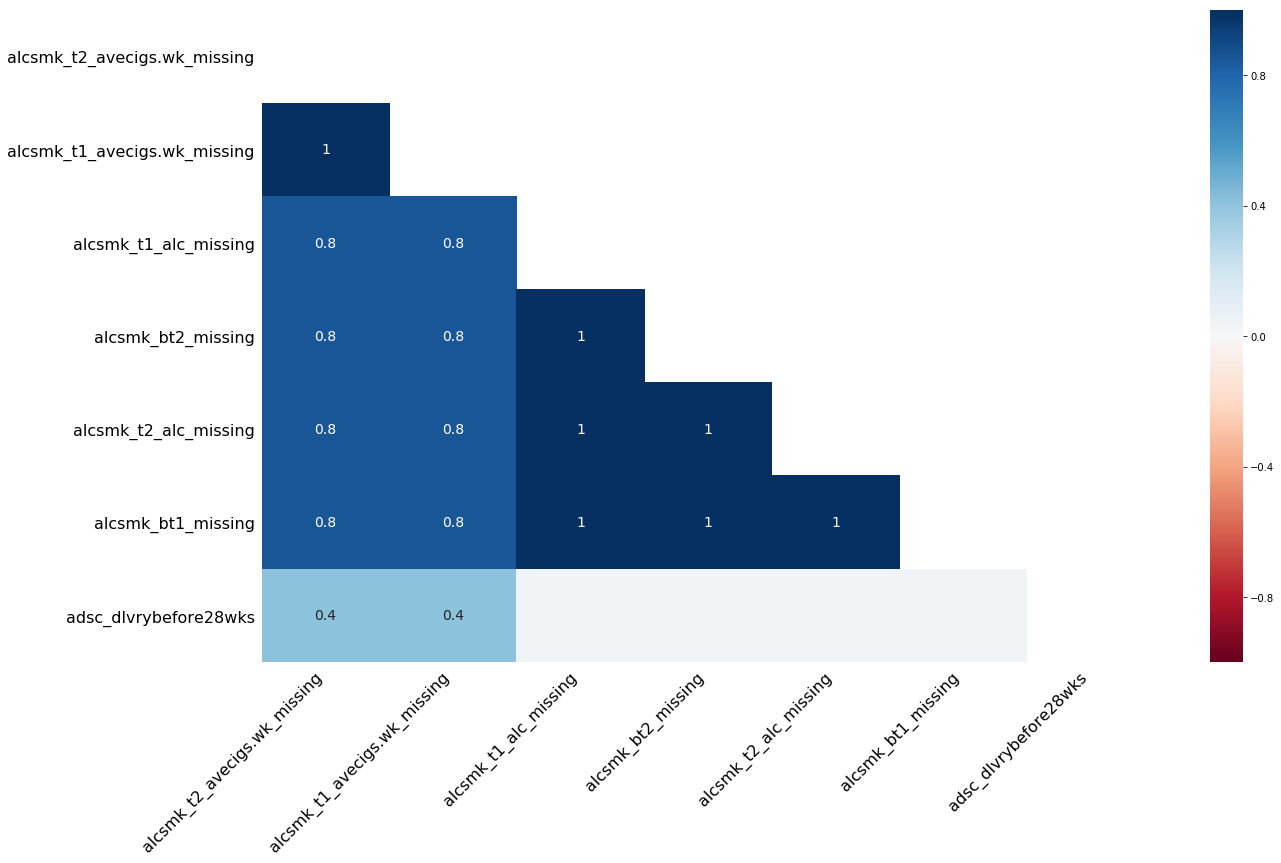

In [313]:
missingno.heatmap(top6y.replace(1,np.nan))

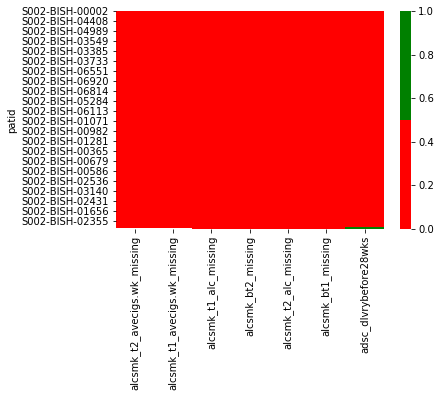

In [310]:
sns.heatmap(top6y.sort_values(by='adsc_dlvrybefore28wks'), vmin=0, vmax=1, cmap=['red','green'])

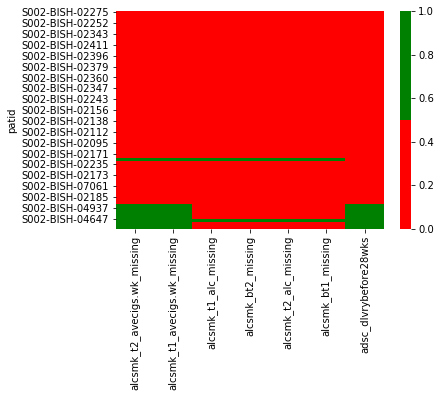

In [314]:
sns.heatmap(top6y.sort_values(by='adsc_dlvrybefore28wks')[-100:], vmin=0, vmax=1, cmap=['red','green'])

# Perfect AUC on Validation
Note that for auc99[43] and auc99[54], we have perfect AUC.

Probably has something to do with the exact event split into training and validation...

In [247]:
print(auc99[42], auc99[53])

203 237


In [256]:
# INPUTS
target = 'adsc_dlvrybefore28wks'
data = toif1pwr_demotoif1pwr_df
seed=237
# AUC 50: 83
# AUC 66: 5, 17, 53, 61, 67, 73, 79, 89, 127
# AUC 83: 2, 11, 19, 31, 37, 41, 43, 71, 97, 101, 103, 107, 109
# AUC 99: 3, 7, 13, 23, 29, 47, 59, 113, 131
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(target_cols+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1).copy()
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]


# Employ Missing Indicator Method
missing_cols = [
    item for item in 
    x.replace(-999999,np.nan).isna().sum().to_frame('missing').query('missing > 0').index.tolist()
]
for col in missing_cols:
    x[col+'_missing'] = [1  if item==-999999 else 0 for item in x[col]]
    x[col] = x[col].replace(-999999, 0)

ptrn = dict()
pval = dict()
perfect = [auc99[42], auc99[53]]
for seed in perfect:
    # Split Data
    x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)
    ptrn[seed] = y_trn.query('adsc_dlvrybefore28wks == 1').index
    pval[seed] = y_val.query('adsc_dlvrybefore28wks == 1').index



In [254]:
ptrn[perfect[0]]

Index(['S002-BISH-04647', 'S002-BISH-05908', 'S002-BISH-06497',
       'S002-BISH-03841', 'S002-BISH-01907', 'S002-BISH-03857',
       'S002-BISH-04628', 'S002-BISH-06632'],
      dtype='object', name='patid')

In [255]:
pval[perfect[0]]

Index(['S002-BISH-02409', 'S002-BISH-04937', 'S002-BISH-03957'], dtype='object', name='patid')

In [257]:
ptrn[perfect[1]]

Index(['S002-BISH-06632', 'S002-BISH-06497', 'S002-BISH-02409',
       'S002-BISH-01907', 'S002-BISH-05908', 'S002-BISH-03841',
       'S002-BISH-03857', 'S002-BISH-04647'],
      dtype='object', name='patid')

In [258]:
pval[perfect[1]]

Index(['S002-BISH-04937', 'S002-BISH-03957', 'S002-BISH-04628'], dtype='object', name='patid')

# The AlcSmk Table

In [267]:
alcsmk = pd.read_csv('../data/raw/File_Early_Signal_alcohol_nicolo_20190924_DB.csv')
print('Any NaNs?', alcsmk.isna().sum().sum())
print('Any -999999s?', alcsmk.replace(-999999,np.nan).isna().sum().sum())

Any NaNs? 0
Any -999999s? 1275


In [270]:
alcsmk.replace(-999999,np.nan).isna().sum().to_frame('nan').query('nan > 0')

,nan
T3_Alc_perday,57
T1_AveCigs.Wk,203
T2_AveCigs.Wk,203
T3_AveCigs.Wk,203
Ave_CigsPreg_Imp,203
Smk_grp,203
Smk_Bi-999999ry,203


In [320]:
import warnings
warnings.filterwarnings(action='ignore') # so many annoying warnings for this cell

# INPUTS
target = 'adsc_dlvrybefore28wks'
data = toif1pwr_demotoif1pwr_df
seed=13  # used to be AUC 1.0
# AUC 50: 83
# AUC 66: 5, 17, 53, 61, 67, 73, 79, 89, 127
# AUC 83: 2, 11, 19, 31, 37, 41, 43, 71, 97, 101, 103, 107, 109
# AUC 99: 3, 7, 13, 23, 29, 47, 59, 113, 131
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
alcsmk_vars = [var for var in data.columns if 'alcsmk' in var]
x = data.drop(target_cols+['sensor_toi_f1_mvt_pwr_mvt41']+alcsmk_vars, axis=1).copy()
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]


# Employ Missing Indicator Method
missing_cols = [
    item for item in 
    x.replace(-999999,np.nan).isna().sum().to_frame('missing').query('missing > 0').index.tolist()
]
for col in missing_cols:
    x[col+'_missing'] = [1  if item==-999999 else 0 for item in x[col]]
    x[col] = x[col].replace(-999999, 0)


# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)

# SMOTE the training data
cats = [idx for idx,col in enumerate(x_trn.columns) if len(x[col].unique()) < 10]
sm = SMOTENC(cats, random_state=seed)
x_trn, y_trn = sm.fit_resample(x_trn.values, y_trn.values.ravel())

# Fit Model
model = LogisticRegression(penalty='l1', solver='liblinear', 
                          random_state=seed)
model.fit(x_trn, y_trn)

# Make Predictions
yp_trn = model.predict(x_trn)
yp_val = model.predict(x_val)


#print('AUC:', roc_auc_score(y_val, yp_val))
    
feature_importance = abs(model.coef_[0])
rank = np.flip(np.argsort(feature_importance))
imps = pd.concat([
    imps,
    pd.DataFrame({
        'ftr': x.columns[rank], 
        'imp': feature_importance[rank], 
        'sign': np.sign(model.coef_[0][rank])
    })])
    
print('AUC:', roc_auc_score(y_val, yp_val))

AUC: 0.4936708860759494


AUC: 0.4972875226039783


In [321]:
target_cols = [
    'adscmat_labortype_spontaneousoraugmented_db', 
    'adsc_dlvry_dt', 
    'adsc_dlvrybefore28wks', 
    'adsc_dlvrybefore34wks', 
    'adsc_dlvryga_dys', 
    'adsc_dlvryga_dys_sbadj']

# Get Full Dataset
dff = pd.read_csv('../data/processed/full_set_v4_20200110_KU.csv')

# Set PatId Index
dff.set_index('patid', inplace=True)

# Remove Cesareans/Inductions
dff.query('adscmat_labortype_spontaneousoraugmented_db == 1', inplace=True)

# Remove records w/ GA@Birth < 25 wks (168 days is last day of week 24, so let's do 170 for clean cut off)
dff.query('adsc_dlvryga_dys >= 170', inplace=True)

# NEW: Remove records w/ GA@Recruitment > 25 weeks
dff.query('adelig_ccga <= 170', inplace=True)
dff.drop('adelig_ccga', axis=1, inplace=True)


# Feature Subsets
#  -- Sensor Cols:       Monica and Toitu Cols (usually; we dropped Monica above)
#  -- Toitu Cols:        Toitu Cols
#  -- Toitu F1 Cols:     Toitu F1 Cols
#  -- Toitu F1 Pwr Cols: Toitu F1 Power Cols (band21, band31, band41)
democlinical_cols = [col for col in dff.columns if 'sensor' not in col]
sensor_cols = [col for col in dff.columns if 'sensor' in col]

dc = dff.drop(sensor_cols, axis=1)

In [323]:
import warnings
warnings.filterwarnings(action='ignore') # so many annoying warnings for this cell

# INPUTS
target = 'adsc_dlvrybefore28wks'
data = dc
seed=13  # used to be AUC 1.0
# AUC 50: 83
# AUC 66: 5, 17, 53, 61, 67, 73, 79, 89, 127
# AUC 83: 2, 11, 19, 31, 37, 41, 43, 71, 97, 101, 103, 107, 109
# AUC 99: 3, 7, 13, 23, 29, 47, 59, 113, 131
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
alcsmk_vars = [var for var in data.columns if 'alcsmk' in var]
x = data.drop(target_cols + alcsmk_vars, axis=1).copy()
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]


# Employ Missing Indicator Method
missing_cols = [
    item for item in 
    x.replace(-999999,np.nan).isna().sum().to_frame('missing').query('missing > 0').index.tolist()
]
for col in missing_cols:
    x[col+'_missing'] = [1  if item==-999999 else 0 for item in x[col]]
    x[col] = x[col].replace(-999999, 0)


# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=seed)

# SMOTE the training data
cats = [idx for idx,col in enumerate(x_trn.columns) if len(x[col].unique()) < 10]
sm = SMOTENC(cats, random_state=seed)
x_trn, y_trn = sm.fit_resample(x_trn.values, y_trn.values.ravel())

# Fit Model
model = LogisticRegression(penalty='l1', solver='liblinear', 
                          random_state=seed)
model.fit(x_trn, y_trn)

# Make Predictions
yp_trn = model.predict(x_trn)
yp_val = model.predict(x_val)


#print('AUC:', roc_auc_score(y_val, yp_val))
    
feature_importance = abs(model.coef_[0])
rank = np.flip(np.argsort(feature_importance))
imps = pd.concat([
    imps,
    pd.DataFrame({
        'ftr': x.columns[rank], 
        'imp': feature_importance[rank], 
        'sign': np.sign(model.coef_[0][rank])
    })])
    
print('AUC:', roc_auc_score(y_val, yp_val))

AUC: 0.4908296943231441


In [324]:
x.shape

(3841, 196)

# El Fin

There you have it, folks!  

Any and all signal comes from Nico's alcsmk table, which is an imputed data table
based on raw alcohol and smoking variables... Columbia wanted us to use it....but it looks
like it has a lot of issues.  The main one is that any pre-term (event) has missing
cigarette vars.  This is the majority of the signal -- basically the answer key.

Why?

We don't know...but it doesn't make for a great model unless it really means something
interesting biologically....  Moreover, being an imputed data table, the point was 
basically to remove missing values.......yet there are still missing values?